In [1]:
import argparse
import os
from os.path import join
from os import listdir
import pandas as pd
import numpy as np
import re

def processing_file(out_name, infolder, outfolder):  #out_name = 'preprocessing'
    
    data_path = infolder
    out_path = outfolder

    path_df = get_path_df(data_path)

    create_if_necessary(out_path)   

    results = []
    to_exclude = []

    for i, row in path_df.iterrows():

        path_to_save = join(out_path, row['fn'])

        raw_file = read_raw_edf(row['full_path'], verbose=False, preload=True)
        df = raw_file.to_data_frame()

        try:
            df, res = process_data(df)
            results.append(['OK', row['full_path'], row['fn'], res])
        except Exception as e:
            results.append(['FAILURE', row['full_path'], row['fn'], str(type(e)) + ': ' + str(e)])
            to_exclude.append(i)
            continue

        df = change_reference(df, 'cz')
        # reduce sfreq to 125Hz
        df = df.iloc[::2, :]
        df.to_csv(path_to_save)

    del path_df['full_path']
    path_df = path_df.loc[~path_df.index.isin(to_exclude)]
    path_df['sfreq'] = 125
    path_df.to_csv(join(out_path, '{}.csv'.format(out_name)), index=False)

    df_results = pd.DataFrame(results, columns=['status', 'full_path', 'fn', 'comment'])
    df_results.to_csv(join(out_path, 'processing_log.csv'), index=False)
    
    return df_results

def create_if_necessary(path):
    if not os.path.exists(path):
        os.makedirs(path)

def change_reference(df, new_ref):
    df_old = df.copy()
    df = df.copy()
    for col in df.columns:
        df[col] = df[col] - df_old[new_ref]
    return df

def process_data(df):
    """
    Returns:
        out_df: pd.DataFrame

    """
    df.set_index('time', inplace=True)
    desired_columns = ['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't3', 'c3', 'cz', 'c4',
                       't4', 't5', 'p3', 'pz', 'p4', 't6', 'o1', 'o2']
    df.columns = [col.lower() for col in df.columns]
    df.columns = [col.replace('eeg ', '') for col in df.columns]
    a1_ref_columns = [(col, col + '-a1') for col in desired_columns]
    a2_ref_columns = [(col, col + '-a2') for col in desired_columns]
    not_found = []
    for col in desired_columns:
        if col not in df.columns:
            not_found.append(col)
    if len(not_found) == 0:
        return df[desired_columns], 'all channels found'
    a1_a2_str = ''
    if 'a1-a2' in df.columns:
        if 'a2' not in df.columns:
            df['a2'] = 0
        else:
            a1_a2_str = '; a1-a2 + a2 present'
        df['a1'] = df['a1-a2'] + df['a2']
    elif 'a2-a1' in df.columns:
        if 'a1' not in df.columns:
            df['a1'] = 0
        else:
            a1_a2_str = '; a2-a1 + a1 present'
        df['a2'] = df['a2-a1'] + df['a1']
    else:
        raise Exception('no ref found or not enough columns' + '; ' + '|'.join(not_found))

    for col, ref_col in a1_ref_columns:
        if ref_col in df.columns:
            df[col] = df[ref_col] + df['a1']
    for col, ref_col in a2_ref_columns:
        if ref_col in df.columns:
            df[col] = df[ref_col] + df['a2']

    not_found = []
    for col in desired_columns:
        if col not in df.columns:
            not_found.append(col)

    if len(not_found) == 0:
        return df[desired_columns], 'all channels found; A1 and A2 references changed' + a1_a2_str

    else:
        raise Exception('not enough columns; A1 and A2 references changed' + a1_a2_str +
                        '; ' + '|'.join(not_found))

def build_df(rows):
    return pd.DataFrame(rows)

def get_path_df(raw_data_path):
    path_chmt = join(raw_data_path, 'trauma')
    path_norm = join(raw_data_path, 'healthy')
    rows = []
    process_path(rows, path_chmt, 'trauma')
    process_path(rows, path_norm, 'healthy')
    return build_df(rows)
    
def process_path(rows, path, target_value, ext='edf'):
    for fn in listdir(path):
        print(fn)
        #if fn in to_exclude:
        #    continue

        if fn[-3:].lower() != ext:
            continue

        full_path = join(path, fn)
        print(full_path)
        
        try:
            sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')

            d = {}
            d['full_path'] = full_path
            d['fn'] = fn.lower().replace(ext, 'csv')
            d['target'] = target_value
            d['sfreq'] = sample.info['sfreq']
            d['channels'] = '|'.join(sorted(sample.info['ch_names']))
            d['n_channels'] = len(sample.info['ch_names'])
            eeg_channels = [ch for ch in sample.info['ch_names'] if 'EEG' in ch]
            d['channels_eeg'] = '|'.join(sorted(eeg_channels))
            d['n_channels_eeg'] = len(eeg_channels)
            d['seconds'] = sample.get_data().shape[1] / d['sfreq']
            rows.append(d)
        except:
            continue

# Preprocessing EEG files

### 1) Looking into EEG data:

In [2]:
from mne.io import read_raw_edf
import numpy as np
import pandas as pd

%matplotlib notebook

In [3]:
foo = read_raw_edf('database/trauma/00b2d6e257e2f615.edf')

Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\00b2d6e257e2f615.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
foo.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1-A1, EEG Fp2-A2, EEG F7-A1, EEG F3-A1, EEG Fz-A1, EEG ...
 chs: 23 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2016-04-20 23:35:55 UTC
 nchan: 24
 projs: []
 sfreq: 250.0 Hz
>

In [5]:
foo2 = read_raw_edf('database/healthy/fba9a25c67d8fe4a.edf')

Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\healthy\fba9a25c67d8fe4a.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [6]:
foo2.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2019-07-07 18:39:06 UTC
 nchan: 21
 projs: []
 sfreq: 250.0 Hz
>

<IPython.core.display.Javascript object>


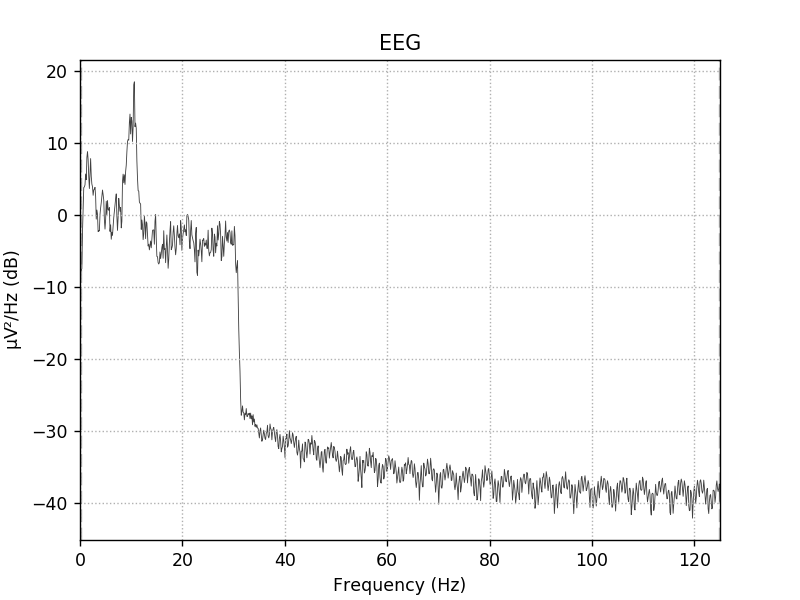

Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-7-d4173972af99>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  foo.plot_psd(picks=['EEG O1-A1']);


<IPython.core.display.Javascript object>


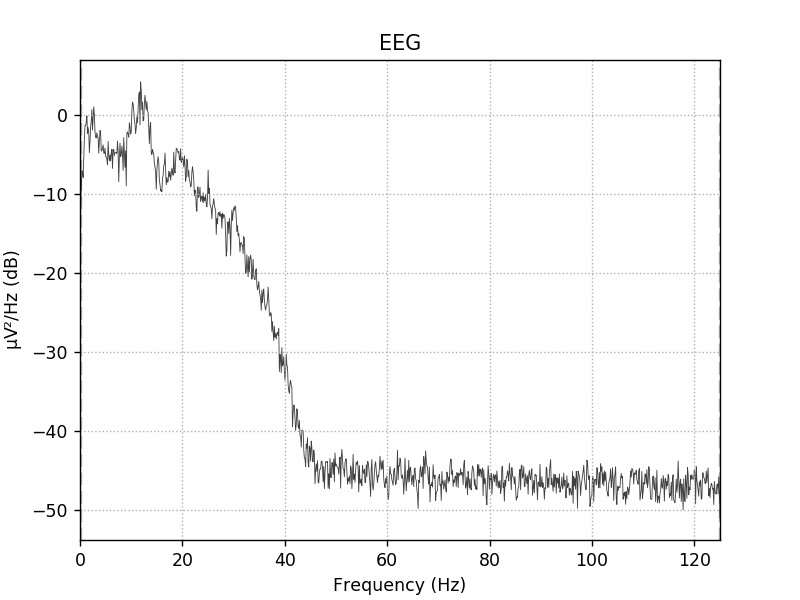

Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-7-d4173972af99>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  foo2.plot_psd(picks=['O1']);


In [7]:
foo.plot_psd(picks=['EEG O1-A1']);
foo2.plot_psd(picks=['O1']);

### Conclusion: 

> Subject records present different names and number of channels!

### 2) Processing input files: 

* Rename channels, discart high freqs, create csv files

In [ ]:
#!pip3.8 install ipynb
#from ipynb.fs.full.pproc_functions import *
#import pandas as pd

In [8]:
df = processing_file('preprocessed', 'database', 'datasets') #out_name, data_path, out_path

00b2d6e257e2f615.edf
database\trauma\00b2d6e257e2f615.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\00b2d6e257e2f615.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
09769097749fb286.edf
database\trauma\09769097749fb286.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\09769097749fb286.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
0b84dd748e7d5edd.edf
database\trauma\0b84dd748e7d5edd.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\0b84dd748e7d5edd.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
158ce5e17a662599.edf
database\trauma\158ce5e17a662599.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR', 'POLY SGR 38: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:

25313f2f5b6854da.edf
database\trauma\25313f2f5b6854da.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\25313f2f5b6854da.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
27502eb3bc2f0ef5.edf
database\trauma\27502eb3bc2f0ef5.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\27502eb3bc2f0ef5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2a4a9f39f461ddbd.edf
database\trauma\2a4a9f39f461ddbd.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\2a4a9f39f461ddbd.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2ba1dbcfc047f2dc.edf
database\trauma\2ba1dbcfc047f2dc.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


Creating raw.info structure...
4089f52684a2e480.edf
database\trauma\4089f52684a2e480.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\4089f52684a2e480.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
43e5fb534a220e35.edf
database\trauma\43e5fb534a220e35.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\43e5fb534a220e35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
47659966be99a2c9.edf
database\trauma\47659966be99a2c9.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\47659966be99a2c9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
47b3e467b578a8d0.edf
database\trauma\47b3e467b578a8d0.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_cou

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


521a5a6f578df78a.edf
database\trauma\521a5a6f578df78a.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\521a5a6f578df78a.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
56062691c4e394fa.edf
database\trauma\56062691c4e394fa.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\56062691c4e394fa.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
5c9ca89c610ef553.edf
database\trauma\5c9ca89c610ef553.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\5c9ca89c610ef553.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
60ccf64fd597d94a.edf
database\trauma\60ccf64fd597d94a.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR', 'POLY SGR 38: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:

Setting channel info structure...
Creating raw.info structure...
77eebdbbf707b292.edf
database\trauma\77eebdbbf707b292.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\77eebdbbf707b292.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
798481734a854593.edf
database\trauma\798481734a854593.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\798481734a854593.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
7efc4155f9445765.edf
database\trauma\7efc4155f9445765.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\7efc4155f9445765.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
7ff1d9cb6521aff3.edf
database\trauma\7ff1d9cb6521aff3.edf
Extracting EDF parameters fr

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning:

8a4e4018d0be4d5b.edf
database\trauma\8a4e4018d0be4d5b.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\8a4e4018d0be4d5b.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
8aa2dbb7668b5ef2.edf
database\trauma\8aa2dbb7668b5ef2.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\8aa2dbb7668b5ef2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
9396b2261349267f.edf
database\trauma\9396b2261349267f.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\9396b2261349267f.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
979afa0cb0a07664.edf
database\trauma\979afa0cb0a07664.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


EDF file detected
Setting channel info structure...
Creating raw.info structure...
a4c28a88c78ef3f5.edf
database\trauma\a4c28a88c78ef3f5.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\a4c28a88c78ef3f5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
a5d1abd4c42d33b0.edf
database\trauma\a5d1abd4c42d33b0.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\a5d1abd4c42d33b0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
a9f950f25473f718.edf
database\trauma\a9f950f25473f718.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\a9f950f25473f718.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
afe90bf080f6d728.edf
database\trauma\afe90bf080f6d728.edf
Extracting

<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR', 'POLY SGR 38: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


EDF file detected
Setting channel info structure...
Creating raw.info structure...
bc8568311c86157d.edf
database\trauma\bc8568311c86157d.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\bc8568311c86157d.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
bc942f2ef343be30.edf
database\trauma\bc942f2ef343be30.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\bc942f2ef343be30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
bd29241c7c07d32a.edf
database\trauma\bd29241c7c07d32a.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\bd29241c7c07d32a.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
bdcff4b8f633033a.edf
database\trauma\bdcff4b8f633033a.edf
Extracting

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR', 'POLY SGR 38: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG 35: EKG, POLY ECG 36: EKG, POLY ECG 37: EKG
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY ECG 35: EKG', 'POLY ECG 36: EKG', 'POLY ECG 37: EKG']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipytho


Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\dbd73fe5be89e495.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
dbfac893f765ffcd.edf
database\trauma\dbfac893f765ffcd.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\dbfac893f765ffcd.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
dccf535148895385.edf
database\trauma\dccf535148895385.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\dccf535148895385.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
de5f468db0da8e3c.edf
database\trauma\de5f468db0da8e3c.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\de5f468db0da8e3c.edf...
EDF file

<ipython-input-1-a49245871d59>:140: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


EDF file detected
Setting channel info structure...
Creating raw.info structure...
fbbf0a6fdc85c055.edf
database\trauma\fbbf0a6fdc85c055.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\fbbf0a6fdc85c055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
fc8b4b29193dedd6.edf
database\trauma\fc8b4b29193dedd6.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\trauma\fc8b4b29193dedd6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
00131107d306b93f.edf
database\healthy\00131107d306b93f.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\healthy\00131107d306b93f.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
02743918e73fcdd4.edf
database\healthy\02743918e73fcdd4.edf
Extract

<ipython-input-1-a49245871d59>:140: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')


03d553f5817d23d3.edf
database\healthy\03d553f5817d23d3.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\healthy\03d553f5817d23d3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
05e88506dc8eb3ae.edf
database\healthy\05e88506dc8eb3ae.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\healthy\05e88506dc8eb3ae.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
06296125a8abd01e.edf
database\healthy\06296125a8abd01e.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_Project2\github\database\healthy\06296125a8abd01e.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
08d3be145b492393.edf
database\healthy\08d3be145b492393.edf
Extracting EDF parameters from D:\Bruna\Documents\Skoltech_courses\NMLBio\project\EEG_

<ipython-input-1-a49245871d59>:25: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY PPG 36: FPG', 'POLY SGR 37: KGR', 'POLY Resp 38: RD']
  raw_file = read_raw_edf(row['full_path'], verbose=False, preload=True)
<ipython-input-1-a49245871d59>:25: RuntimeWarning: Physical range is not defined in following channels:
POLY ECG FPG, POLY Resp 36: RD, POLY SGR 37: KGR
  raw_file = read_raw_edf(row['full_path'], verbose=False, preload=True)
<ipython-input-1-a49245871d59>:25: RuntimeWarning: 2 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR']
  raw_file = read_raw_edf(row['full_path'], verbose=False, preload=True)
<ipython-input-1-a49245871d59>:25: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
['POLY Resp 36: RD', 'POLY SGR 37: KGR', 'POLY SGR 38: KGR']
  raw_file = read_raw_edf(row['full_path'], verbose=False, preload=True)
<ipython-input-1-a49245871d59>:25: 

In [9]:
data_pre = pd.read_csv('datasets/preprocessed.csv')
data_pre

,fn,target,sfreq,channels,n_channels,channels_eeg,n_channels_eeg,seconds
0,00b2d6e257e2f615.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,23,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,130.0
1,09769097749fb286.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,116.0
2,0b84dd748e7d5edd.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,27,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,102.0
3,158ce5e17a662599.csv,trauma,125,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,29,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,21,38.0
4,17df70855fa4922a.csv,trauma,125,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,23,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,21,48.0
...,...,...,...,...,...,...,...,...
223,fba9a25c67d8fe4a.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,102.0
224,fc0aa833b9c5fece.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,55.0
225,fc65d230b5eb3722.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,88.0
226,fd3d621074b54f8f.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,54.0


In [10]:
test = pd.read_csv('datasets/00b2d6e257e2f615.csv')
test

,time,fp1,fp2,f7,f3,fz,f4,f8,t3,c3,cz,c4,t4,t5,p3,pz,p4,t6,o1,o2
0,0,2.410417,-7.575848,-2.032640,6.927484,6.058728,5.471705,-1.936019,-3.520398,3.510258,0.0,5.804131,-1.085967,-2.992123,-0.569312,-2.239710,2.025004,3.669290,0.978986,-0.580421
1,8,-1.560327,-9.227624,-4.912555,5.170093,3.792470,2.327807,-6.888914,1.760291,3.294073,0.0,3.618895,-4.966350,-1.259965,2.478193,-0.865954,2.357364,1.285802,0.634531,-1.592596
2,16,-8.772799,-13.129642,-10.153239,0.022070,-2.143294,-3.791313,-12.959389,2.717401,1.237399,0.0,1.775821,-8.056277,0.477224,4.377776,0.770634,2.291125,-2.137900,-0.337533,-4.088813
3,24,-14.735832,-18.472326,-13.370274,-5.805767,-8.706285,-9.421131,-16.814056,-0.612577,1.173128,0.0,1.500380,-9.199782,3.623782,7.358412,3.800843,2.146034,-4.610825,1.228084,-5.684733
4,32,-17.038885,-22.681846,-14.337056,-10.633168,-12.705429,-11.682575,-17.095246,-3.240066,3.031146,0.0,1.413106,-8.458817,7.015995,10.950778,7.831953,1.869546,-5.489605,4.939248,-5.090341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16245,129960,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,0.0,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16246,129968,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,0.0,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16247,129976,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,0.0,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16248,129984,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,0.0,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021


### Conclusion: 

> Now all subjects have the same name and number of channels. 

> Channel 'cz' is 0 because is the reference channel. It should be drop from data!

In [13]:
# Remove 'cz' column
import tqdm as tqdm

for i in tqdm.trange(data_pre.shape[0]):
    rec = pd.read_csv('datasets/{}'.format(data_pre.fn[i]))
    rec = rec.drop('cz', axis=1)
    rec.to_csv('datasets/{}'.format(data_pre.fn[i]), index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [03:26<00:00,  1.10it/s]


In [14]:
test = pd.read_csv('datasets/00b2d6e257e2f615.csv')
test

,time,fp1,fp2,f7,f3,fz,f4,f8,t3,c3,c4,t4,t5,p3,pz,p4,t6,o1,o2
0,0,2.410417,-7.575848,-2.032640,6.927484,6.058728,5.471705,-1.936019,-3.520398,3.510258,5.804131,-1.085967,-2.992123,-0.569312,-2.239710,2.025004,3.669290,0.978986,-0.580421
1,8,-1.560327,-9.227624,-4.912555,5.170093,3.792470,2.327807,-6.888914,1.760291,3.294073,3.618895,-4.966350,-1.259965,2.478193,-0.865954,2.357364,1.285802,0.634531,-1.592596
2,16,-8.772799,-13.129642,-10.153239,0.022070,-2.143294,-3.791313,-12.959389,2.717401,1.237399,1.775821,-8.056277,0.477224,4.377776,0.770634,2.291125,-2.137900,-0.337533,-4.088813
3,24,-14.735832,-18.472326,-13.370274,-5.805767,-8.706285,-9.421131,-16.814056,-0.612577,1.173128,1.500380,-9.199782,3.623782,7.358412,3.800843,2.146034,-4.610825,1.228084,-5.684733
4,32,-17.038885,-22.681846,-14.337056,-10.633168,-12.705429,-11.682575,-17.095246,-3.240066,3.031146,1.413106,-8.458817,7.015995,10.950778,7.831953,1.869546,-5.489605,4.939248,-5.090341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16245,129960,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16246,129968,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16247,129976,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021
16248,129984,-0.000126,-0.000112,0.001224,0.000374,0.000494,-0.000631,0.000843,0.000338,-0.000111,-0.001071,0.000294,0.001006,0.001553,0.002003,0.000720,0.000304,0.000111,0.000021


### 3) Looking for differences in time:

In [20]:
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


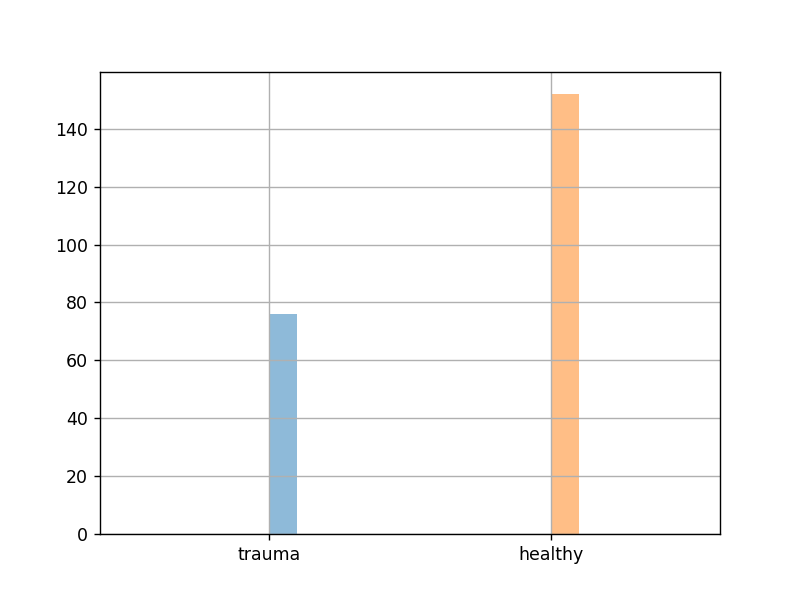

In [21]:
data_pre[data_pre['target'] == 'trauma']['target'].hist(alpha=0.5, label='trauma')
data_pre[data_pre['target'] == 'healthy']['target'].hist(alpha=0.5, label='trauma')

<IPython.core.display.Javascript object>


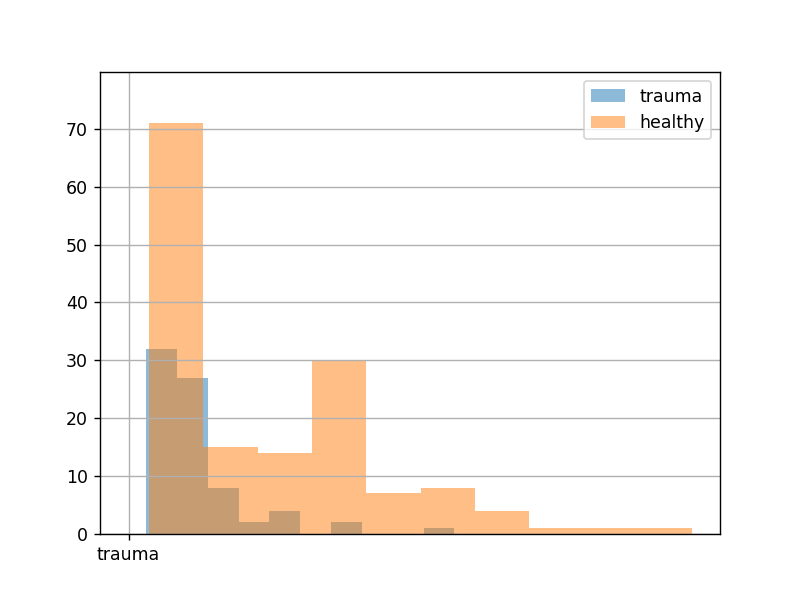

In [16]:
data_pre[data_pre['target'] == 'trauma']['seconds'].hist(alpha=0.5, label='trauma')
data_pre[data_pre['target'] == 'healthy']['seconds'].hist(alpha=0.5, label='healthy')
plt.legend()

### Conclusion:

> Subjects present different time lenght, so some strategy need to be applied to get same time records for all subjects.

### 4) Getting new dataset with equal lenght pieces

* Crop equal length pieces of EGG.
* Drop every subject with record shorter than 60 secs.
* Build a dataset.

In [22]:
# first strategy
def get_extracts(records, targets, sfreq):
    """
    records = [np.array[n_samples, n_channels], np.array, np.array, ..]
    targets = ['trauma', 'healthy', ...]
    """
    extracts = []
    targets_of_pieces = []
    subjects = []
    
    for subj, record, target in zip(subjects_all, records, targets):
        if len(record) < 60 * sfreq:
            continue
        extracts.append(record[:60*sfreq])
        targets_of_pieces.append(target)
        subjects.append(subj)

    return subjects, extracts, targets_of_pieces

In [24]:
records = []
targets = []
subjects_all = []
for i in tqdm.trange(data_pre.shape[0]):
    rec = pd.read_csv('datasets/{}'.format(data_pre.fn[i]))
    records.append(rec)
    targets.append(data_pre.target[i])   
    subjects_all.append(data_pre.fn[i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:22<00:00, 10.18it/s]


In [25]:
subjects, extracts, targets = get_extracts(records, targets, 125)
print('Previous dataset: ', data_pre.shape[0], 'New dataset: ', len(extracts))
print((data_pre.shape[0] - len(extracts)), 'subjects were discarded')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Previous dataset:  228 New dataset:  185
43 subjects were discarded


In [27]:
print('subjects discarded: ')
discarded = []
for i in data_pre.fn:
    if i not in subjects:
        discarded.append(i)

for i,j in zip(data_pre.fn, data_pre.target):
    if i in discarded:
        print(i, j)        

subjects discarded: 
158ce5e17a662599.csv trauma
17df70855fa4922a.csv trauma
1f424c8e1fd31218.csv trauma
210a90133b1f39a3.csv trauma
2330fe97fb1ce051.csv trauma
338af1bcca222684.csv trauma
521a5a6f578df78a.csv trauma
60ccf64fd597d94a.csv trauma
658887126b842cc3.csv trauma
6c84ec66cd63463f.csv trauma
82a82088871ee4d5.csv trauma
8a4e4018d0be4d5b.csv trauma
979afa0cb0a07664.csv trauma
9da473e5673c3331.csv trauma
a258dcc1a94be8b2.csv trauma
a5d1abd4c42d33b0.csv trauma
b5012e61209910e3.csv trauma
bdcff4b8f633033a.csv trauma
c0b262576ff2706f.csv trauma
c36279cff8c47d21.csv trauma
d6ef7170ab9b9414.csv trauma
f29671c9a1f76d03.csv trauma
f594ba8684b869be.csv trauma
fbbf0a6fdc85c055.csv trauma
fc8b4b29193dedd6.csv trauma
03d553f5817d23d3.csv healthy
0c45a50d14794d06.csv healthy
19b09e184ed62cbf.csv healthy
800a945a1742f4c3.csv healthy
80de8bafdba944b5.csv healthy
821379f9ce55f642.csv healthy
933c09f8e087a40a.csv healthy
b3f39dcea9ef0900.csv healthy
c0d1b583cb401295.csv healthy
c1cdac82bf0969c9.c

In [28]:
new_data = pd.DataFrame(zip(subjects_all, targets), columns=['fn','target'])
new_data.to_csv('datasets/processed.csv', index=False)

In [33]:
data_pre

,fn,target,sfreq,channels,n_channels,channels_eeg,n_channels_eeg,seconds
0,00b2d6e257e2f615.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,23,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,130.0
1,09769097749fb286.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,116.0
2,0b84dd748e7d5edd.csv,trauma,125,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,27,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-...,21,102.0
3,158ce5e17a662599.csv,trauma,125,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,29,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,21,38.0
4,17df70855fa4922a.csv,trauma,125,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,23,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...,21,48.0
...,...,...,...,...,...,...,...,...
223,fba9a25c67d8fe4a.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,102.0
224,fc0aa833b9c5fece.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,55.0
225,fc65d230b5eb3722.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,88.0
226,fd3d621074b54f8f.csv,healthy,125,A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...,21,NaN,0,54.0


<IPython.core.display.Javascript object>


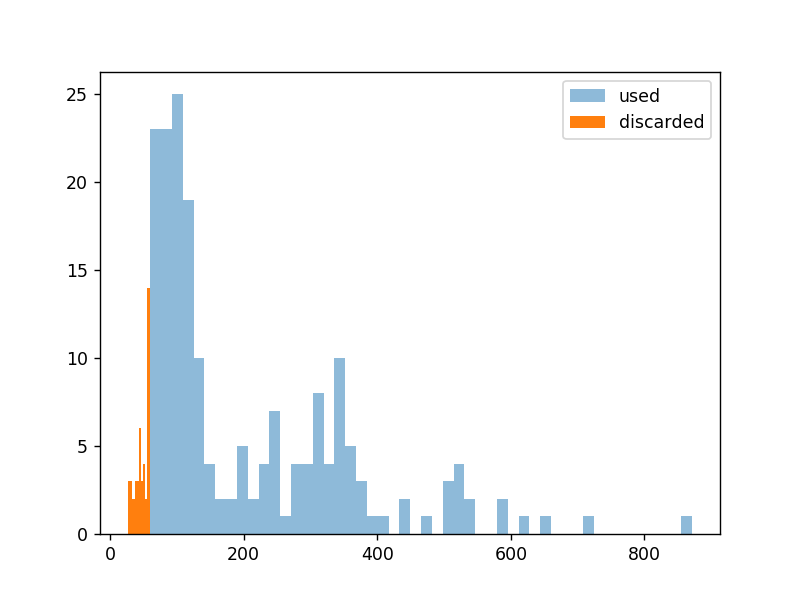

In [38]:
%matplotlib notebook

time_dis = []
time_used = []
for i,j in zip(data_pre.fn, data_pre.seconds):
    if i in discarded:
        time_dis.append(j)
    
    else: time_used.append(j)

plt.hist(time_used,bins=50, alpha=0.5, label='used')
plt.hist(time_dis, alpha=1, label='discarded')
plt.legend()